# Rental Inventory Analysis

## Introduction

My analysis is focused on the rental properties located in Manhattan, New York. With Manhattan being the most popular borough in New York City, it was appropriate to use its data as a way to analyze the rental inventory trends from before, during (03/2020 - 12/2020), and after the COVID-19 pandemic. In analyzing the rental inventory in the city, I sought to answer questions regarding the effect of the pandemic on inventory:

- Which neighborhoods, generally, see the most rental properties available?
- How did COVID affect available rental properties in Manhattan's neighborhoods?
- What trends were found in Manhattan's submarkets prior to, during, and post-pandemic?

### StreetEasy Dataset

For this notebook, I looked at the inventory of rental units in Manhattan from the years 2018 to 2022. The data was courtesy of StreetEasy, a very popular source for housing and property in New York City. It is known to be a very reliable website for New Yorkers to find available housing, so they have access to a lot of data regarding the housing market in New York City. In addition, their data is generally granular, with inventory statistics available by month, and by neighborhood or submarket, since 2010 and updated constantly. This allowed for my analysis to be reliable and allowed for trends to appear more meaningfully.

#### Note on the Dataset

It should be noted that there is potential bias in this data, as the date ranges are not exactly equal to each other. During COVID accounts for 9 months, between March and December of 2020, while pre-COVID (January 2018 to February 2020) and post-COVID (January 2021 to December 2022) cover about 2 years each. This may lead to potential skewing of data during COVID, where other factors such as peak times for renting may be unintentionally affecting. However,  the focus of this notebook is to demonstrate the impact that the pandemic had on rental inventory by comparing it to before and after. Splitting the data in this fashion gives the best outlook.

### Maptiler API

To represent each neighborhood's average inventory from 2018 to 2022 visually, I leveraged Maptiler's API reference to their Cloud Services to retrieve the latitudes and longitudes of each neighborhood in Manhattan. This free service allowed me to search for locations by name, so I was able to retrieve most of the neighborhoods' coordinates (while hard-coding the handful that were not found). With this, I was able to plot them onto a map of Manhattan, allowing for an interactive and engaging visualization of inventory in the city.


In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import hvplot.pandas

# Import API key
from config import maptiler_apikey

In [162]:
# Create a function to clean the CSV file for Manhattan and desired date range
def clean_dataframe(df):

    # Use the melt function to unpivot the DataFrame and create a single column for dates
    clean_df = df.melt(id_vars=['areaName', 'Borough', 'areaType'], var_name='Date', value_name='Inventory')
    
    # Narrow the DataFrame to Manhattan
    clean_manhattan_df = clean_df[(clean_df['Borough'] == 'Manhattan')]

    # Loop through the DataFrame to search for desired date range and append to empty list
    row_range = []
    for index, row in clean_manhattan_df.iterrows():
        if row['Date'][:4] == '2018' or row['Date'][:4] == '2019' or row['Date'][:4] == '2020' or row['Date'][:4] == '2021' or row['Date'][:4] == '2022':
            row_range.append(row)

    # Create DataFrame from list
    final_df = pd.DataFrame(row_range).reset_index(drop=True)

    # Convert 'Date' column to datetime format
    final_df['Date'] = pd.to_datetime(final_df['Date'])
    
    return final_df

In [163]:
# Import CSV for rental inventory in NYC and create a DataFrame
csvpath_rent = "Resources/rentalInventory_All.csv"
rental_inventory_df = pd.read_csv(csvpath_rent)

# Use the function to narrow the DataFrame for the desired location and dates
rent_manhattan_inv = clean_dataframe(rental_inventory_df)

# Keep only the 'neighborhood' areaType
rent_manhattan_inv = rent_manhattan_inv[rent_manhattan_inv['areaType'] == 'neighborhood'].reset_index(drop=True)

# Display new DataFrame
rent_manhattan_inv.head()

,areaName,Borough,areaType,Date,Inventory
0,Battery Park City,Manhattan,neighborhood,2018-01-01,209
1,Central Harlem,Manhattan,neighborhood,2018-01-01,657
2,Central Park South,Manhattan,neighborhood,2018-01-01,75
3,Chelsea,Manhattan,neighborhood,2018-01-01,895
4,Chinatown,Manhattan,neighborhood,2018-01-01,62


# Plotting Average Rent Inventory by Neighborhood

In [16]:
neighborhoods = rent_manhattan_inv['areaName'].unique()
found_lat_long = {}
lat_long_notfound = []

for neighborhood in neighborhoods:

    # Done to remove '/' from 'Stuyvesant Town/PCV'
    if '/' in neighborhood:
        neighborhood = neighborhood.replace('/', ' ')

    # Initialize neighborhood for API search
    query = f'{neighborhood}, Manhattan'
    
    # Set base URL
    base_url = f"https://api.maptiler.com/geocoding/{query}.json?key={maptiler_apikey}"

    # Make a GET request and change it to JSON
    name_address = requests.get(base_url).json()

    try:
        # Check if the location found by the GET request is for Manhattan
        if (', '.join(name_address['features'][0]['place_name'].split(', ')[0:2])) == query:

            # Extract the coordinates and assign to the dictionary
            found_lat_long[neighborhood] = name_address['features'][0]['geometry']['coordinates']
            print(f"{query} was found!")
        else:
            # Assign query name to a list of neighborhoods not found
            print(f"{query} did not match")
            lat_long_notfound.append(query)
    except:
        print(f"{query} was not found")
        lat_long_notfound.append(query)
        pass

found_lat_long


Battery Park City, Manhattan was found!
Central Harlem, Manhattan did not match
Central Park South, Manhattan did not match
Chelsea, Manhattan was found!
Chinatown, Manhattan was found!
Civic Center, Manhattan was found!
East Harlem, Manhattan was found!
East Village, Manhattan was found!
Financial District, Manhattan was found!
Flatiron, Manhattan did not match
Gramercy Park, Manhattan was found!
Greenwich Village, Manhattan was found!
Hamilton Heights, Manhattan was found!
Inwood, Manhattan was found!
Little Italy, Manhattan was found!
Lower East Side, Manhattan was found!
Marble Hill, Manhattan was found!
Midtown, Manhattan was found!
Midtown East, Manhattan was found!
Midtown South, Manhattan was found!
Midtown West, Manhattan did not match
Morningside Heights, Manhattan was found!
Nolita, Manhattan did not match
Roosevelt Island, Manhattan was found!
Soho, Manhattan did not match
Stuyvesant Town PCV, Manhattan did not match
Tribeca, Manhattan was found!
Upper East Side, Manhattan 

{'Battery Park City': [-74.0169370919466, 40.71101673544539],
 'Chelsea': [-74.0015284717083, 40.746490628528385],
 'Chinatown': [-73.99625055491924, 40.716491497942705],
 'Civic Center': [-74.00240421295166, 40.71367933109386],
 'East Harlem': [-73.94250009208918, 40.79472223506761],
 'East Village': [-73.98736137896776, 40.729269020403876],
 'Financial District': [-74.00927100330591, 40.70766832644719],
 'Gramercy Park': [-73.98676768876612, 40.7379753607984],
 'Greenwich Village': [-73.99656604975462, 40.7319804282054],
 'Hamilton Heights': [-73.95006190985441, 40.82414516746835],
 'Inwood': [-73.92049491405487, 40.86925797610624],
 'Little Italy': [-73.99821527302265, 40.71927305271932],
 'Lower East Side': [-73.98680582642555, 40.71593573211237],
 'Marble Hill': [-73.91042925417423, 40.87629833454393],
 'Midtown': [-73.98478008806705, 40.755116903906696],
 'Midtown East': [-73.97247109562159, 40.75982211197815],
 'Midtown South': [-73.98425102233887, 40.74984191057065],
 'Mornings

In [101]:
# Create a DataFrame from the resulting dictionary, with the neighborhoods as the index
manhattan_lat_long = pd.DataFrame(found_lat_long).T

# Rename columns
manhattan_lat_long.columns = ['Longitude', 'Latitude']


In [102]:
# Hard-code the missing latitudes and longitudes and add them to the DataFrame
manhattan_lat_long.loc['Central Harlem', 'Longitude'] = -73.9423528972
manhattan_lat_long.loc['Central Harlem', 'Latitude'] = 40.8054167783

manhattan_lat_long.loc['Central Park South', 'Longitude'] = -73.977668970226
manhattan_lat_long.loc['Central Park South', 'Latitude'] = 40.76635058859312

manhattan_lat_long.loc['Flatiron', 'Longitude'] = -73.987162718
manhattan_lat_long.loc['Flatiron', 'Latitude'] = 40.737997048

manhattan_lat_long.loc['Midtown West', 'Longitude'] = -73.994508
manhattan_lat_long.loc['Midtown West', 'Latitude'] = 40.763186

manhattan_lat_long.loc['Nolita', 'Longitude'] = -73.9951515
manhattan_lat_long.loc['Nolita', 'Latitude'] = 40.722542

manhattan_lat_long.loc['Soho', 'Longitude'] = -74.0
manhattan_lat_long.loc['Soho', 'Latitude'] = 40.721497114

manhattan_lat_long.loc['Stuyvesant Town/PCV', 'Longitude'] = -73.97332944
manhattan_lat_long.loc['Stuyvesant Town/PCV', 'Latitude'] = 40.725663764

manhattan_lat_long.loc['West Harlem', 'Longitude'] = -73.962898
manhattan_lat_long.loc['West Harlem', 'Latitude'] = 40.816357

# Display the complete DataFrame
manhattan_lat_long

,Longitude,Latitude
Battery Park City,-74.016937,40.711017
Chelsea,-74.001528,40.746491
Chinatown,-73.996251,40.716491
Civic Center,-74.002404,40.713679
East Harlem,-73.942500,40.794722
East Village,-73.987361,40.729269
Financial District,-74.009271,40.707668
Gramercy Park,-73.986768,40.737975
Greenwich Village,-73.996566,40.731980
Hamilton Heights,-73.950062,40.824145


In [334]:
# Group DataFrame by neighborhood for merging
grouped_inv = rent_manhattan_inv.groupby(['areaName']).mean('inventory').round()

# Merge lat/longs to the DataFrame
merged_lat_long = pd.merge(grouped_inv, manhattan_lat_long, right_index=True, left_index=True, how='outer')

# Reset the index and rename the column
neighborhood_lat_longs = merged_lat_long.reset_index(drop=False)
neighborhood_lat_longs = neighborhood_lat_longs.rename(columns={'index': 'Neighborhoods'})

# Display new DataFrame
neighborhood_lat_longs

,Neighborhoods,Inventory,Longitude,Latitude
0,Battery Park City,222.0,-74.016937,40.711017
1,Central Harlem,953.0,-73.942353,40.805417
2,Central Park South,82.0,-73.977669,40.766351
3,Chelsea,963.0,-74.001528,40.746491
4,Chinatown,87.0,-73.996251,40.716491
5,Civic Center,1.0,-74.002404,40.713679
6,East Harlem,469.0,-73.942500,40.794722
7,East Village,1314.0,-73.987361,40.729269
8,Financial District,810.0,-74.009271,40.707668
9,Flatiron,477.0,-73.987163,40.737997


In [350]:
manhattan_map_plot = neighborhood_lat_longs.hvplot.points(
    'Longitude',
    'Latitude',
    geo=True,
    tiles="OSM",
    title="Manhattan Neighborhood Rentals",
    color='Neighborhoods',
    alpha = 0.75,
    s='Inventory',
    scale=1,
    frame_width=800,
    frame_height=800
)

manhattan_map_plot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Neighborhoods,Inventory)

## Analysis and Conclusions

Looking at the map of the neighborhoods' average inventory, we can see that there is a large number of rental units in the Upper East Side and Upper West Side, as well as Midtown Manhattan. The Upper East Side had an average of about 3,184 rental units in inventory between 2018 and 2022, while the Upper West Side had an average of about 2,753 units in inventory. This would generally suggest a higher demand for rental units in these areas of central Manhattan. In addition, there is a notably large number of neighborhoods in downtown Manhattan, making this submarket another popular area for people to rent.

# Average Rental Inventory Before, During, and After COVID

In [139]:
pre_covid_rent_inv = rent_manhattan_inv[rent_manhattan_inv['Date'].between("2018-01-01", "2020-02-01")]
pre_covid_rent_inv

,areaName,Borough,areaType,Date,Inventory
0,Battery Park City,Manhattan,neighborhood,2018-01-01,209
1,Central Harlem,Manhattan,neighborhood,2018-01-01,657
2,Central Park South,Manhattan,neighborhood,2018-01-01,75
3,Chelsea,Manhattan,neighborhood,2018-01-01,895
4,Chinatown,Manhattan,neighborhood,2018-01-01,62
...,...,...,...,...,...
827,Upper East Side,Manhattan,neighborhood,2020-02-01,1911
828,Upper West Side,Manhattan,neighborhood,2020-02-01,1878
829,Washington Heights,Manhattan,neighborhood,2020-02-01,435
830,West Harlem,Manhattan,neighborhood,2020-02-01,55


In [140]:
covid_rent_inv = rent_manhattan_inv[rent_manhattan_inv['Date'].between("2020-03-01", "2020-12-01")]
covid_rent_inv

,areaName,Borough,areaType,Date,Inventory
832,Battery Park City,Manhattan,neighborhood,2020-03-01,155
833,Central Harlem,Manhattan,neighborhood,2020-03-01,599
834,Central Park South,Manhattan,neighborhood,2020-03-01,81
835,Chelsea,Manhattan,neighborhood,2020-03-01,691
836,Chinatown,Manhattan,neighborhood,2020-03-01,59
...,...,...,...,...,...
1147,Upper East Side,Manhattan,neighborhood,2020-12-01,5380
1148,Upper West Side,Manhattan,neighborhood,2020-12-01,4652
1149,Washington Heights,Manhattan,neighborhood,2020-12-01,975
1150,West Harlem,Manhattan,neighborhood,2020-12-01,121


In [141]:
post_covid_rent_inv = rent_manhattan_inv[rent_manhattan_inv['Date'].between("2021-01-01", "2022-12-01")]
post_covid_rent_inv

,areaName,Borough,areaType,Date,Inventory
1152,Battery Park City,Manhattan,neighborhood,2021-01-01,376
1153,Central Harlem,Manhattan,neighborhood,2021-01-01,1448
1154,Central Park South,Manhattan,neighborhood,2021-01-01,124
1155,Chelsea,Manhattan,neighborhood,2021-01-01,1651
1156,Chinatown,Manhattan,neighborhood,2021-01-01,141
...,...,...,...,...,...
1915,Upper East Side,Manhattan,neighborhood,2022-12-01,1926
1916,Upper West Side,Manhattan,neighborhood,2022-12-01,1638
1917,Washington Heights,Manhattan,neighborhood,2022-12-01,449
1918,West Harlem,Manhattan,neighborhood,2022-12-01,61


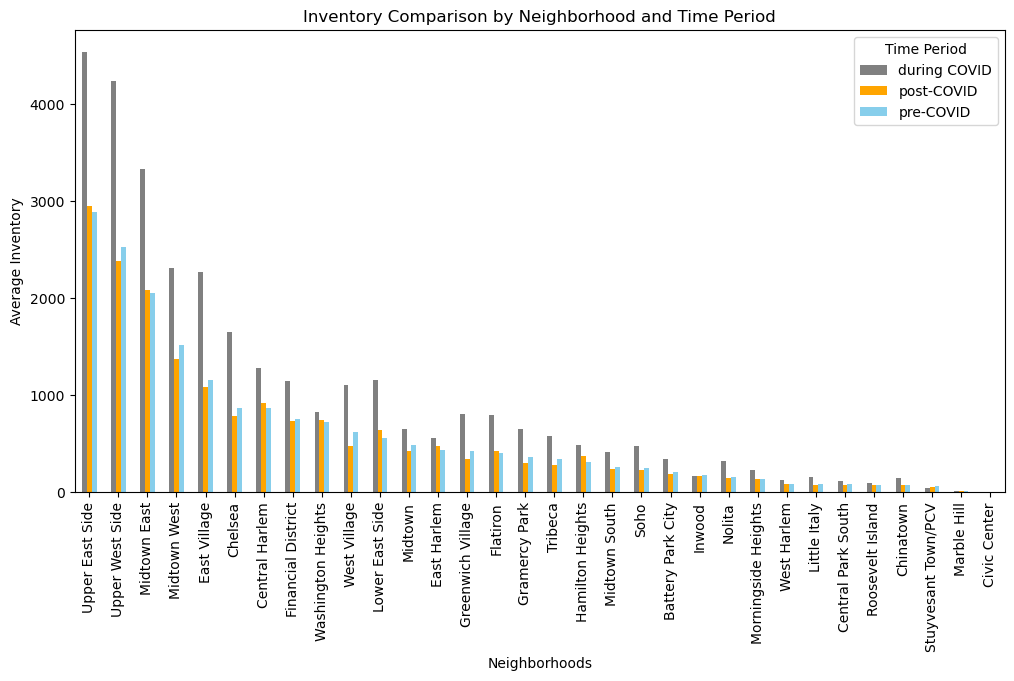

In [401]:
# Group each DataFrame by neighborhood and average the inventory
grouped_precovid = pre_covid_rent_inv.groupby(['areaName']).mean('Inventory').sort_values('Inventory').reset_index()
grouped_precovid['period'] = 'pre-COVID'
grouped_covid = covid_rent_inv.groupby(['areaName']).mean('Inventory').sort_values('Inventory').reset_index()
grouped_covid['period'] = 'during COVID'
grouped_postcovid = post_covid_rent_inv.groupby(['areaName']).mean('Inventory').sort_values('Inventory').reset_index()
grouped_postcovid['period'] = 'post-COVID'
grouped = pd.concat([grouped_precovid, grouped_covid, grouped_postcovid]).reset_index()

# Create a pivot DataFrame to plot pre-, during, and post-covid using 'period' as column sets
pivot_df = grouped.pivot(index='areaName', columns='period', values='Inventory').sort_values('pre-COVID', ascending=False)

# Plotting
pivot_df.plot(kind='bar', color=['grey', 'orange', 'skyblue'], figsize=(12, 6))
plt.title('Inventory Comparison by Neighborhood and Time Period')
plt.xlabel('Neighborhoods')
plt.ylabel('Average Inventory')
plt.xticks(rotation='vertical')
plt.legend(title='Time Period')

# Display the plot
plt.show()

## Analysis and Conclusion

This bar graph demonstrates the average inventory of each neighborhood from pre-COVID, during COVID, and post-COVID. As discussed prior, the areas with the most rental inventory include the Upper East and West Sides, Midtown, and neighborhoods in Downtown Manhattan. Prior to the pandemic, we can see that the average inventory for many of the neighborhoods was slightly greater than their inventory post-COVID, with a few exceptions. However, the most notable trend here is how much more inventory was found during March to December of 2020, the beginning of the pandemic. We can see that pre-COVID, the Upper East Side's average rental inventory was 2,885 units, and that number jumped to 4,533 units during the start of COVID. We can see that, due to the pandemic, much fewer people began to rent units in Manhattan. This would then lead to a massive jump in inventory as shown for almost every neighborhood in the dataset. With fewer people wanting to move into the congested areas of manhattan, it is expected that rental units would be more prolific as a result.

Moving forward, another interesting trend here is the average rental units during COVID and post-COVID, from 2021 to 2022. Again, in the Upper East Side, the average inventory post-COVID was about 2,885 units, a large drop from the 4,533 during COVID. This similar drop is found in most other neighborhoods, including the Upper West Side, parts of Midtown, and Chelsea. It seems that rental inventory was able to regress back to the general levels it was at before COVID, suggesting a more typical amount of people who began to rent units in Manhattan after 2020. The numbers post-COVID are generally at the same level as the numbers pre-COVID. From this, it is reasonable to suggest that the COVID-19 pandemic's initial effect on the spike in 2020 did not affect the average inventory per neighborhood post-COVID, and that Manhattan's rental inventory was able to recover.


# Trends by Manhattan Submarket Before, During, and After Covid

In [301]:
# Use the function to get a new DataFrame
manhattan_submarkets = clean_dataframe(rental_inventory_df)

# Keep only the 'submarket' areaType
manhattan_submarkets = manhattan_submarkets[manhattan_submarkets['areaType'] == 'submarket'].reset_index(drop=True)

# Add columns for year, quarter, and a combined year_quarter
manhattan_submarkets['Year'] = manhattan_submarkets['Date'].dt.year
manhattan_submarkets['Quarter'] = manhattan_submarkets['Date'].dt.quarter
manhattan_submarkets['Year_Quarter'] = manhattan_submarkets['Year'].astype(str) + ' Q' + manhattan_submarkets['Quarter'].astype(str)


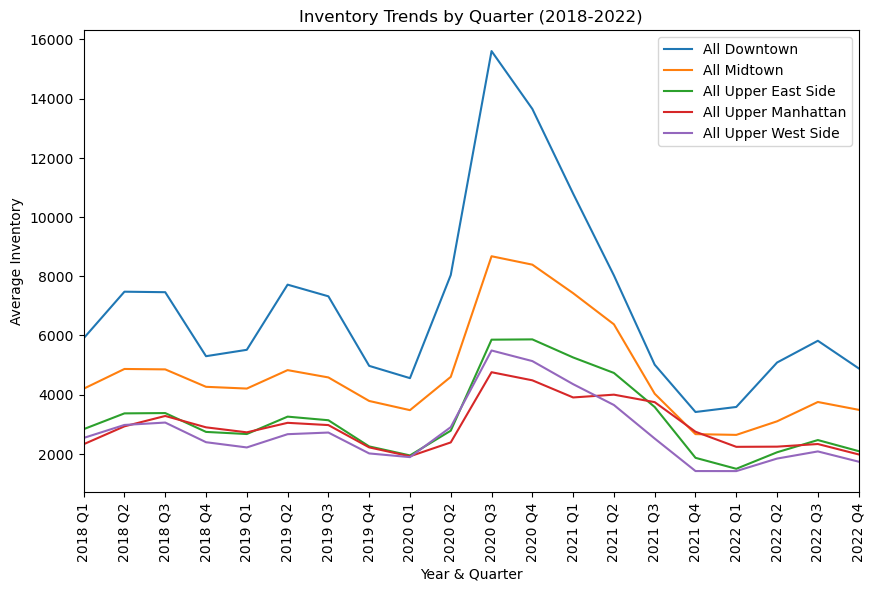

In [399]:
# Group the DataFrame by quarter and get the average inventory
man_sub_group = manhattan_submarkets.groupby(['Year_Quarter', 'areaName'], as_index=True).mean('Inventory').reset_index()
man_sub_pivot = man_sub_group.pivot(index='Year_Quarter', columns='areaName', values='Inventory')

# Set x-axis ticks
x_axis = [i for i in range(len(man_sub_pivot.index))]

# Plotting data
man_sub_pivot.plot(figsize=(10, 6))

plt.ylabel('Average Inventory')
plt.xlabel('Year & Quarter')
plt.xticks(x_axis, man_sub_pivot.index, rotation='vertical')
plt.xlim(0, 19)
plt.legend(loc='upper right')
plt.title('Inventory Trends by Quarter (2018-2022)')

# Display data
plt.show()

## Analysis and Conclusion

Analyzing the trends in average inventory by quarter, we can see many notable trends.